In [1]:
import numpy as np
import os
import pickle

import gym
import matplotlib.pyplot as plt
#from scripts.buffer_utils import LoadSequenceDataset
%matplotlib inline

In [2]:
import h5py

In [3]:
import collections

In [4]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [5]:
import pdb

In [6]:
def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

In [7]:

def load_data(data_path):
    data_dict = {}
    with h5py.File(data_path, "r", libver="latest", swmr=True) as dataset_file:
        for k in get_keys(dataset_file):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]
    return data_dict

In [42]:

tasks = ['walker2d-medium-replay-v2', 'walker2d-medium-v2', 'walker2d-medium-expert-v2',
         'hopper-medium-replay-v2', 'hopper-medium-v2', 'hopper-medium-expert-v2',
         'halfcheetah-medium-replay-v2', 'halfcheetah-medium-v2', 'halfcheetah-medium-expert-v2',]
         

env_list = []
data_list = []
for task in tasks:
    env = gym.make(task)
    data = env.get_dataset()
    
    env_list.append(env)
    data_list.append(data)

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


In [43]:
def sequence_dataset(dataset, kitchen=True):
    sequences = []

    N = dataset["rewards"].shape[0]
    data_ = collections.defaultdict(list)
    use_timeouts = "timeouts" in dataset

    episode_step = 0
    for i in range(N):
        done_bool = bool(dataset["terminals"][i])
        if use_timeouts:
            final_timestep = dataset["timeouts"][i]
        else:
            final_timestep = episode_step == env.max_episode_steps - 1

        for k in ["observations", "rewards", "actions", "terminals"]:
            if "metadata" in k:
                continue
            data_[k].append(dataset[k][i])

        if done_bool or final_timestep:
            episode_step = 0
            episode_data = {}
            for k in data_:
                episode_data[k] = np.array(data_[k])

            if kitchen:
                episode_data = process_kitchen_episode(episode_data)
            sequences.append(episode_data)
            data_ = collections.defaultdict(list)
            
        episode_step += 1
    return sequences

def process_kitchen_episode(episode):
    rewards_ = episode["rewards"][1:] - episode["rewards"][:-1]
    rewards = np.concatenate([episode["rewards"][:1], rewards_], axis=0)
    episode["rewards"] = rewards

    obs = episode["observations"]
    episode["observations"] = obs[:, :30]  # remove the goal
    return episode

In [45]:
sequence_data_list = []
for data in data_list:
    sequence = sequence_dataset(data, kitchen=False)
    sequence_data_list.append(sequence)


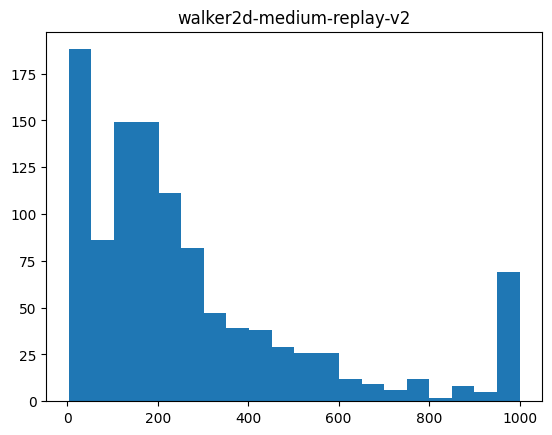

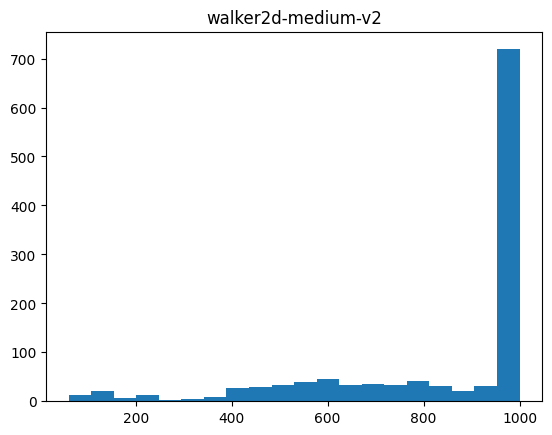

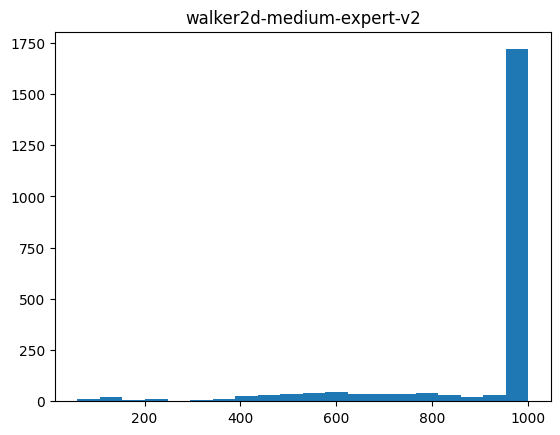

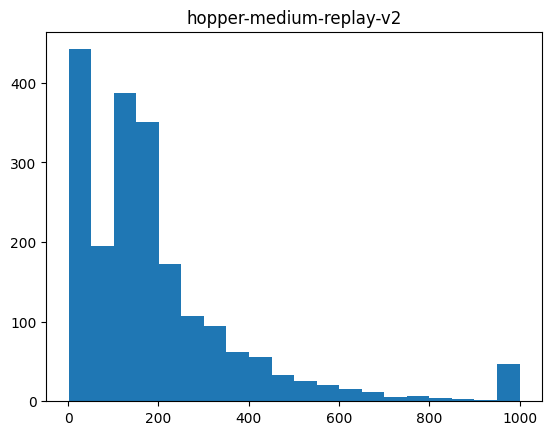

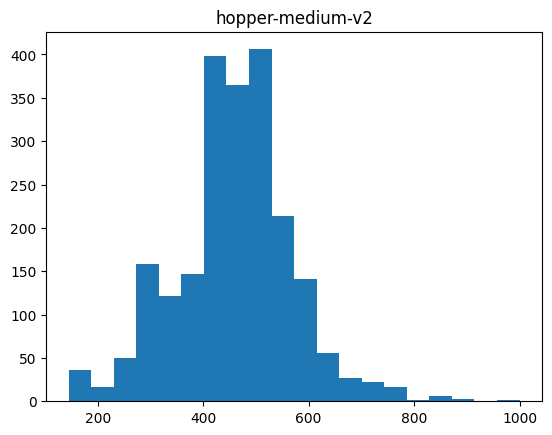

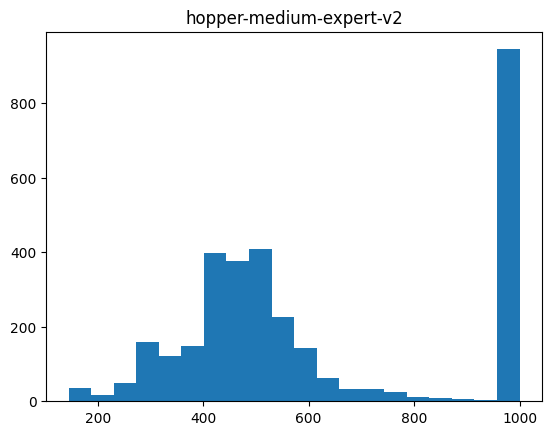

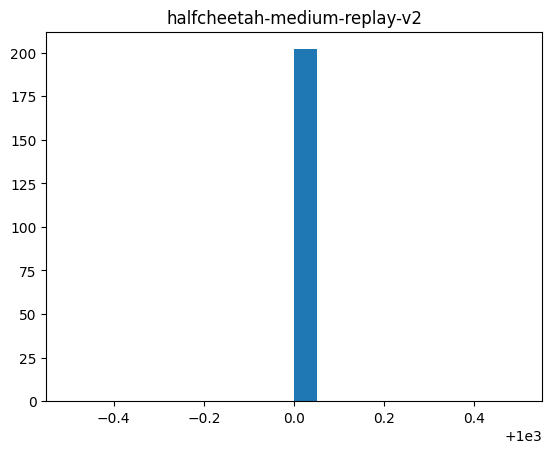

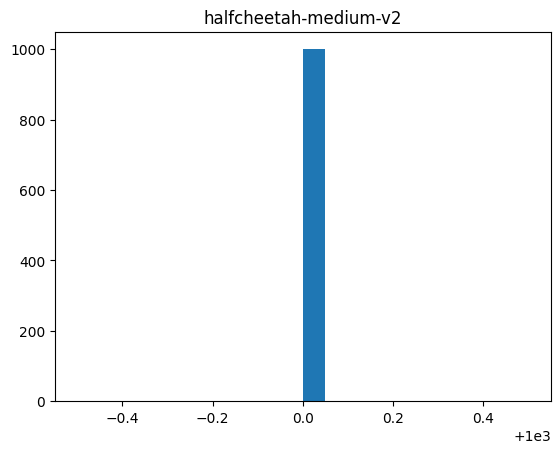

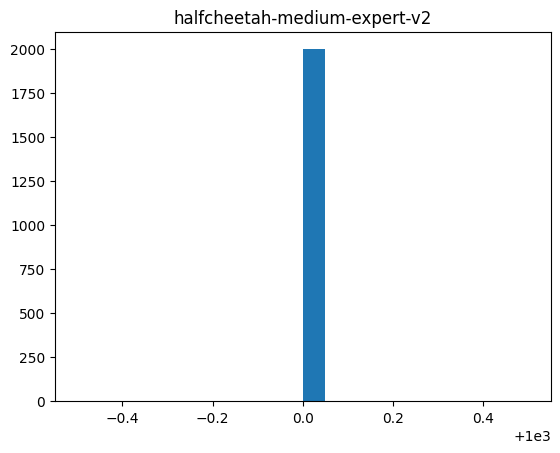

In [47]:
for i in range(len(tasks)):
    data_sequence_len = np.array([seq['observations'].shape[0] for seq in sequence_data_list[i]])
    task = tasks[i]
    plt.hist(data_sequence_len, bins=20)
    plt.title(task)
    plt.show()

In [48]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rewards']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

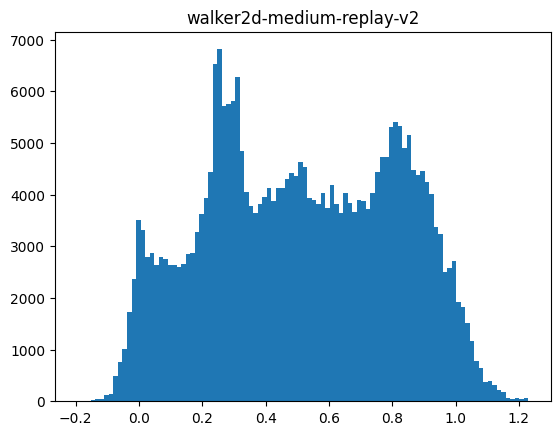

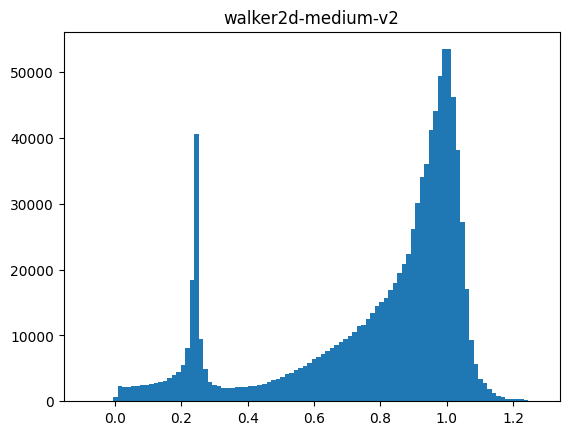

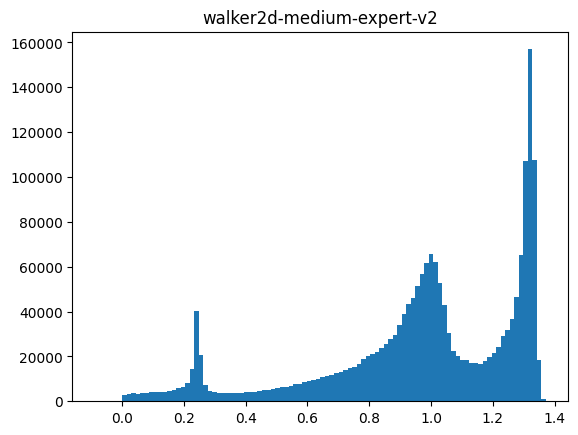

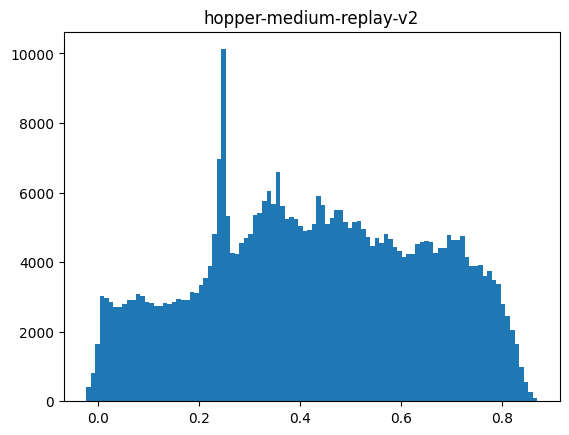

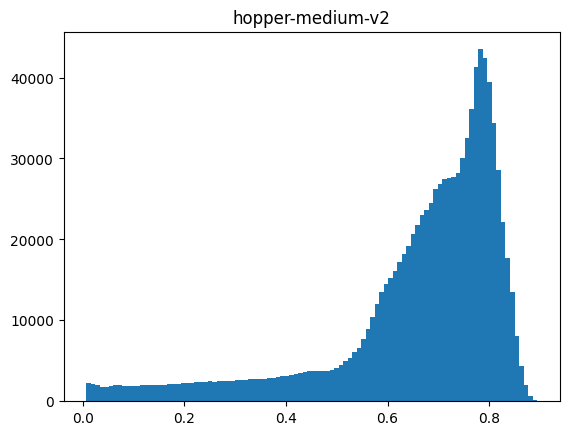

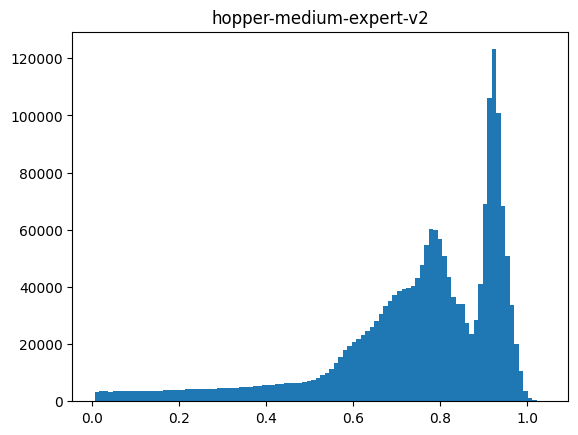

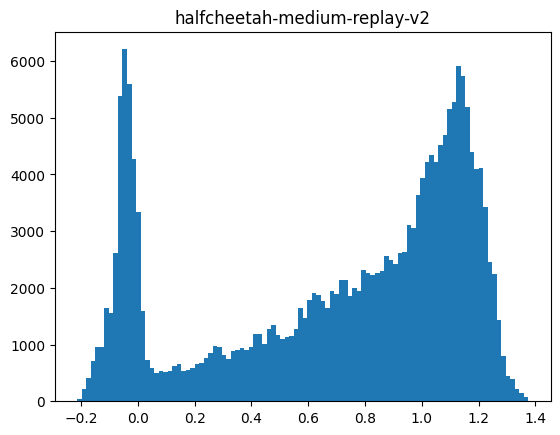

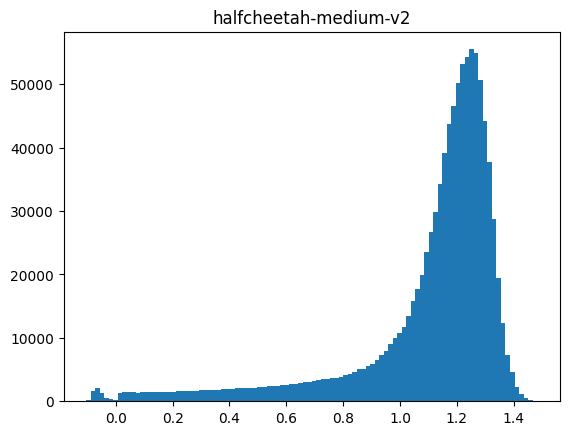

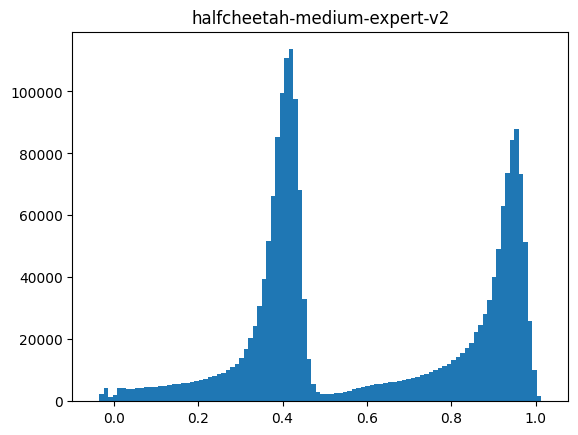

In [51]:
sequence_return_list = []
scale = [400, 400, 400, 400, 400, 400, 400, 400, 1200]

for i in range(len(tasks)):
    sequence_return = np.array(comp_epi_return(sequence_data_list[i]))
    sequence_return_list.append(sequence_return)
    task = tasks[i]
    plt.hist(sequence_return / scale[i], bins=100)
    plt.title(task)
    plt.show()

### Gym-MuJoCo short trajectories

In [56]:
def task_dataset(seq_dataset):
    
    tasks = []
    
    for seq in seq_dataset:
        
        task_data = collections.defaultdict(list)
        rewards = seq['rewards']
        
        l = rewards.shape[0]
        for i in range(l):
            
            for k in seq:
                task_data[k].append(seq[k][i])
            
            if (i+1) % 100 == 0:
                for k in task_data:
                    task_data[k] = np.array(task_data[k])
                tasks.append(task_data)
                task_data = collections.defaultdict(list)
        
        
        if len(task_data) > 0:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
        
        
    return tasks

In [58]:
task_dataset_list = [task_dataset(seq) for seq in sequence_data_list]

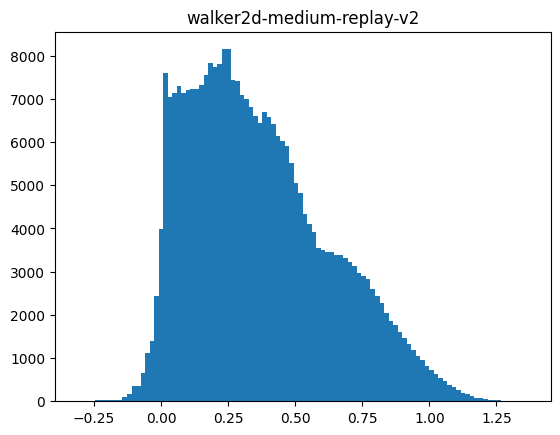

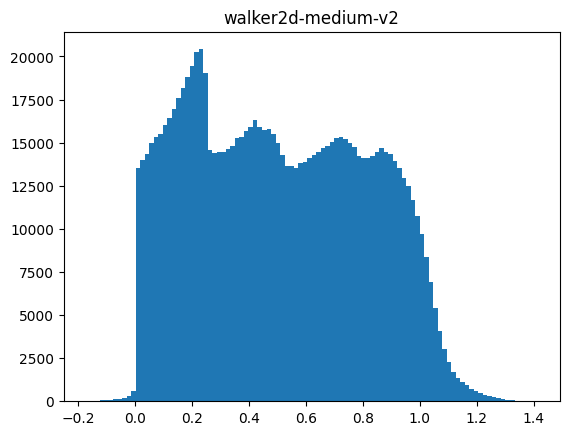

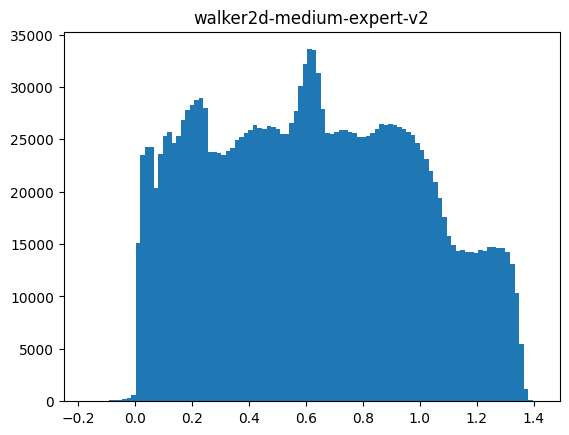

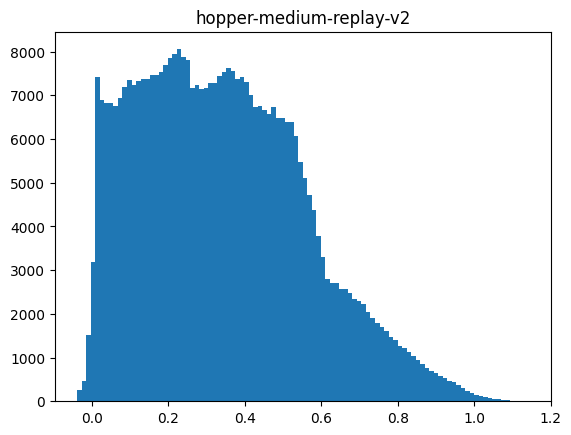

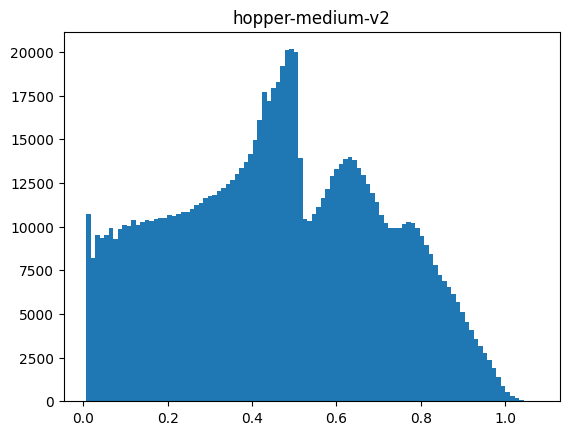

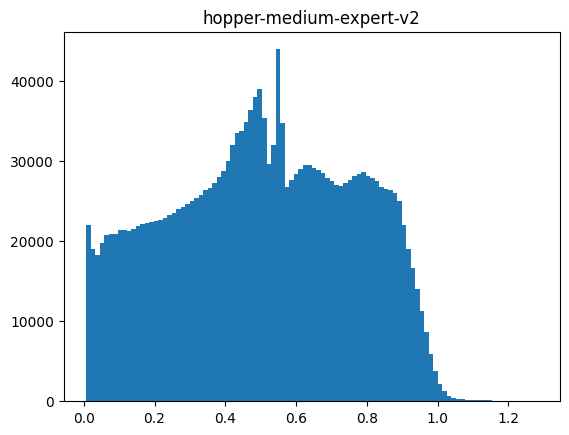

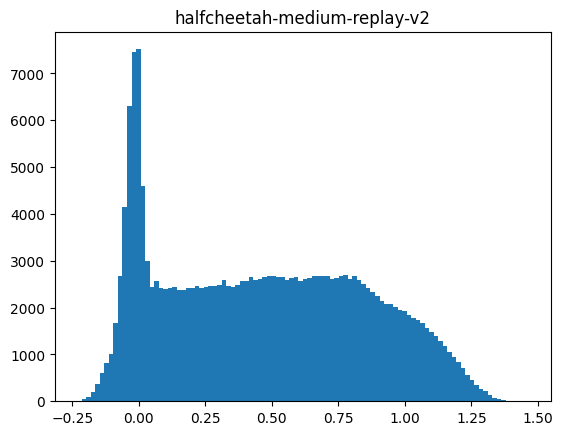

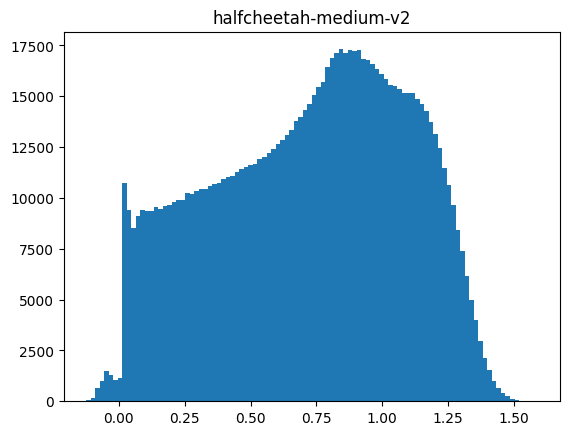

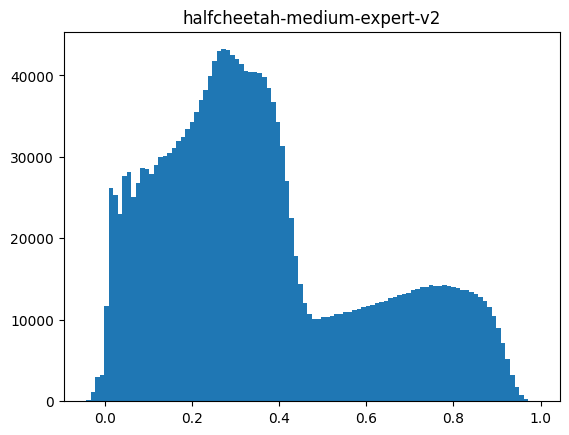

In [62]:
task_return_list = []
scale = [250, 250, 250, 250, 250, 250, 250, 250, 800]

for i in range(len(tasks)):
    task_return = np.array(comp_epi_return(task_dataset_list[i]))
    task_return_list.append(task_return)
    task = tasks[i]
    plt.hist(task_return / scale[i], bins=100)
    plt.title(task)
    plt.show()

In [71]:
len(task_dataset_list[1])

10241

In [72]:
len(sequence_data_list[1])

1190

### Using Mean of two end states

In [73]:
n_clusters = [5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(task_dataset_list[1])):

    mean_states = np.array([task_dataset_list[1][idx]['observations'][0], task_dataset_list[1][idx]['observations'][-1]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")
    

 ============= clustering with center of two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.50
Calinski-Harabasz Index: 2331.57
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.49
Calinski-Harabasz Index: 1689.76
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.18
Davies-Bouldin Index: 1.54
Calinski-Harabasz Index: 1206.06
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.16
Davies-Bouldin Index: 1.47
Calinski-Harabasz Index: 829.25


(array([133., 231., 108., 517., 303., 126.,  75.,  77., 142.,  91.,  75.,
         57.,  60.,  37.,  20.,  36.,   4.,   2.,   1.,   3.]),
 array([  1. ,  12.9,  24.8,  36.7,  48.6,  60.5,  72.4,  84.3,  96.2,
        108.1, 120. , 131.9, 143.8, 155.7, 167.6, 179.5, 191.4, 203.3,
        215.2, 227.1, 239. ]),
 <BarContainer object of 20 artists>)

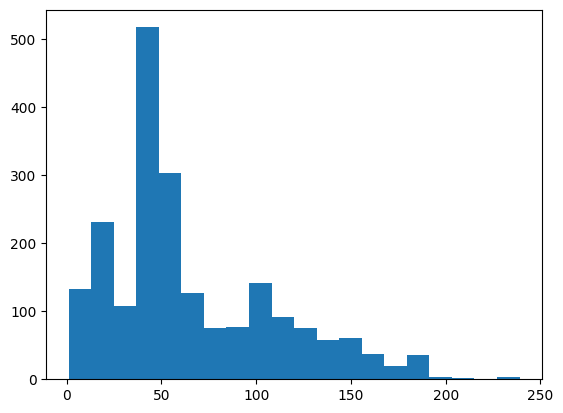

In [114]:
task_len = np.array([t['rewards'].shape[0] for t in tasks])
plt.hist(task_len, bins=20)

In [82]:
(task_len >= 60).sum() / task_len.shape[0]

0.3441077441077441

In [17]:
task_r = np.array([sum(t['rewards']) for t in tasks])

(array([   2.,  676., 1416.,    4.]),
 array([-1,  0,  1,  2,  3]),
 <BarContainer object of 4 artists>)

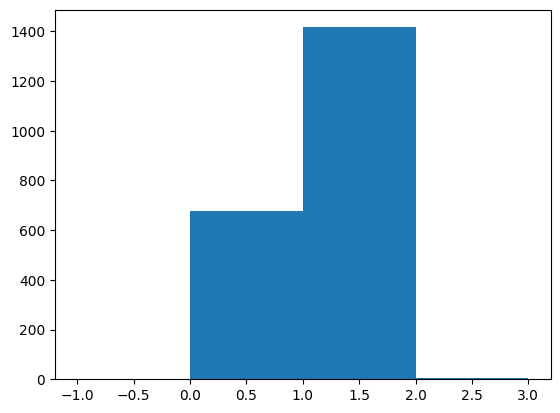

In [25]:
plt.hist(task_r, bins=[-1,0,1,2,3])

In [102]:
tasks[2]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
      dtype=float32)

In [105]:
episodes[1]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [117]:
zero_rewards_idx = np.where(task_r==0.0)[0]

In [118]:
zero_rewards_idx.shape

(676,)

In [97]:
task_len[zero_rewards_idx]

array([  4,   8,   4,   6, 153,   9,  10,  17,  60,   7,   6,   2,   2,
         5,   8,  10,   5,   4,   6,   3,   7,  82,  99,   6,   2,   6,
         4,   2,   2,   2,   6,   5,   4,   4,   2,   6,   2,   2,   4,
         2,   4,   5,   3,   3,   5,   3,   3,   4,   3,   2,   2,   7,
         3,   2,   9,   3,   4,   3,   3,   2,   5,   4,   2,   7,   8,
         8,   4,  99, 132])

In [92]:
len(tasks)

1485

In [72]:
tasks[zero_rewards_idx[4]]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

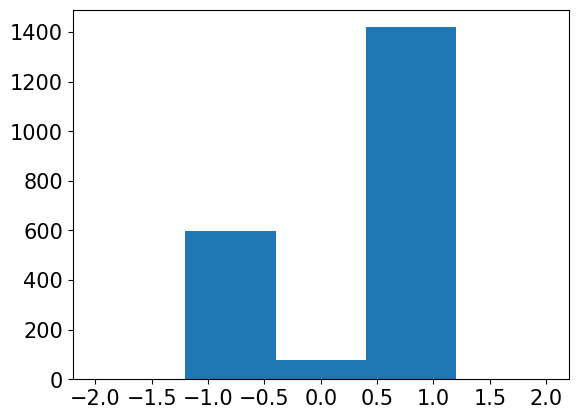

In [53]:
plt.hist(task_r, bins=5)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [35]:
partial_return = np.array(comp_epi_return(tasks))

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

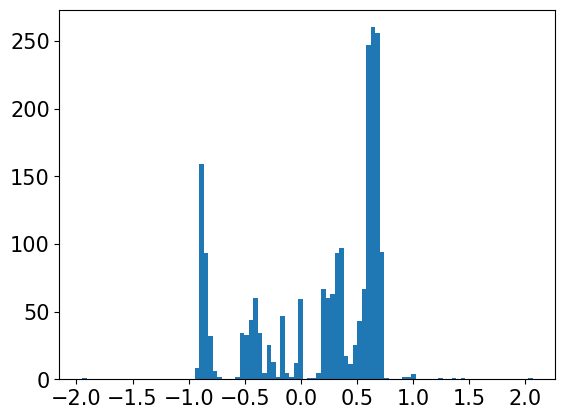

In [46]:
plt.hist(partial_return_v2, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

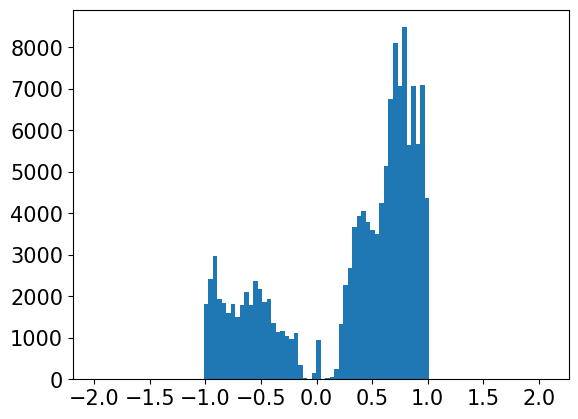

In [36]:
plt.hist(partial_return, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [37]:
partial_return_v2 = np.array(comp_epi_return_v2(tasks))

In [118]:
tasks[85921]['rewards']

IndexError: list index out of range

In [107]:
horizon = 60
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [110]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
print(" ============= clustering with last state ============ ")

for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][-1, :30])

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with last state ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.39
Calinski-Harabasz Index: 20792.33
Silhouette Score: 0.19
Davies-Bouldin Index: 1.61
Calinski-Harabasz Index: 14948.81
Silhouette Score: 0.21
Davies-Bouldin Index: 1.40
Calinski-Harabasz Index: 10769.71
Silhouette Score: 0.22
Davies-Bouldin Index: 1.42
Calinski-Harabasz Index: 8045.16
Silhouette Score: 0.23
Davies-Bouldin Index: 1.38
Calinski-Harabasz Index: 6088.27


In [48]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    print(" ============= clustering with whole sequence ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))


for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    print(" ============= clustering with two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with sequence mean ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.88
Calinski-Harabasz Index: 8099.23
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.77
Calinski-Harabasz Index: 6544.18
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.81
Calinski-Harabasz Index: 4461.71
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 3263.22
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 2717.38
 ============= clustering with two end states ============ 
Silhouette Score: 0.23
Davies-Bouldin Index: 1.58
Calinski-Harabasz Index: 9475.58
 ============= clustering with two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.66
Calinski-Harabasz Index: 7339.54

In [51]:
horizon = 40
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [52]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

print(" ============= clustering with whole sequence ============ ")

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    
    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))

print(" ============= clustering with two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

print(" ============= clustering with sequence mean ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

print(" ============= clustering with center of two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.18
Davies-Bouldin Index: 1.87
Calinski-Harabasz Index: 15482.61
 number of clusters: 5 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.78
Calinski-Harabasz Index: 13464.25
 number of clusters: 10 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 10800.71
 number of clusters: 20 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.52
Calinski-Harabasz Index: 7636.55
 number of clusters: 40 ->:
Silhouette Score: 0.26
Davies-Bouldin Index: 1.45
Calinski-Harabasz Index: 5982.83
 ============= clustering with two end states ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.20
Davies-Bouldin Index: 1.80
Calinski-Harabasz Index: 15901.84
 number of clusters: 5 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 14338.28
 number of clusters: 10 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.73
Calinski-Harabasz Index:

In [27]:
episodes[0]['rewards'].shape

(228,)